# Coefficients and Stats

In [106]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, plot_roc_curve

import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pwd

/Users/chris/github/reddit_nlp


In [4]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Reddit, Visualizer, Labeler

In [5]:
!pwd

/Users/chris/github/reddit_nlp/util


In [6]:
# list to get data for
subreddit_list = ['datascience','machinelearning','dataengineering','python','aws']

# load data using dataloader module
df = dataloader.data_selector(subreddit_list, source='sqlite')

# what we expected?
for sub in subreddit_list:
    print(sub, len(df[df['subreddit'] == sub]))

df.info()
df.sample(10)

Connection to SQLite DB successful
datascience 4402
machinelearning 4967
dataengineering 4883
python 4657
aws 4986
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23895 entries, 0 to 23894
Data columns (total 3 columns):
title        23895 non-null object
subreddit    23895 non-null object
date         23895 non-null object
dtypes: object(3)
memory usage: 560.2+ KB


,title,subreddit,date
17490,How to get a matrix with polynomial factors fr...,python,2020-04-14
13402,Prefect Now Fully Open Source,dataengineering,2020-04-10
2799,[Research] Intuitive Gaussian Mixture Estimati...,machinelearning,2020-03-29
11399,[HELP] Measuring Innovation,datascience,2020-04-10
11833,[Discussion] Does IJCAI-PRICAI 2020 have a reb...,machinelearning,2020-04-10
16266,[D] Should I take a subpar ML/NLP PhD offer? I...,machinelearning,2020-04-14
3281,2 Cars - A Brain Challenge created on Python (...,python,2020-03-29
379,Wrapper over AWS Session Manager to SSH using ...,aws,2020-03-29
20061,Investigating performance issues with Amazon C...,aws,2020-04-20
19658,Amazon FSx file share - multi-region,aws,2020-04-20


In [7]:
X = df['title']
y = df['subreddit']

In [8]:
labeler = Labeler()
labeler.fit(y)
y = labeler.transform(y)
classes = labeler.classes_
labeler.encodings_

{'aws': 0,
 'datascience': 1,
 'machinelearning': 2,
 'python': 3,
 'dataengineering': 4}

In [9]:
useless_words = set(['using', 'lambda', 's3', 'does', 'looking', 'help', 'new', 'data', 'science', 'scientist', 'machine', 'learning', 'use', 'need', 'engineer', 'engineering'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [10]:
# lemmatizer? for scientist vs scientist

In [11]:
tfidf = TfidfVectorizer(max_df=0.7, max_features=6000, ngram_range=(1,2), stop_words=custom_stop_words)
logreg = LogisticRegression(max_iter=1000)
pipe = Pipeline([('tfidf', tfidf),('logreg', logreg)])

In [12]:
model = pipe.fit(X, y)

In [13]:
model.score(X, y)

0.9263862732789286

In [14]:
# load best model here

In [15]:
# make sure to cross_val on X and y, not X_train and y_train or data will be split twice
cross_val_score(model, X, y, cv=StratifiedKFold(shuffle=True))

array([0.86336054, 0.8606403 , 0.86084955, 0.85352584, 0.85896631])

# Coefficients

In [ ]:
if hasattr(model, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

In [ ]:
# only works for linear models with coefficients
coef_dict = {}
for i, sub in enumerate(classes):
    coef_dict[sub] = pd.DataFrame(
                        data=model.named_steps.logreg.coef_[i],
                        index=model.named_steps.tfidf.get_feature_names()
                        )

In [ ]:
for sub, df in coef_dict.items():

    plt.figure(figsize=(16, 12))
    plt.style.use('seaborn-poster')

    top_10 = df.sort_values(0, ascending=False)[0].head(10)
    bottom_10 = df.sort_values(0, ascending=False)[0].tail(10)
    top_and_bottom = pd.DataFrame(data=top_10.append(bottom_10))
    sns.barplot(x=top_and_bottom[0], y=top_and_bottom.index, palette='Blues_d');

    plt.title(f'Feature Importance for {sub.upper()}', fontsize=20)
    plt.xlabel('Coefficients', fontsize=18)

# Predictions

In [54]:
y_pred = model.predict(X)

In [55]:
y_probs = model.predict_proba(X)

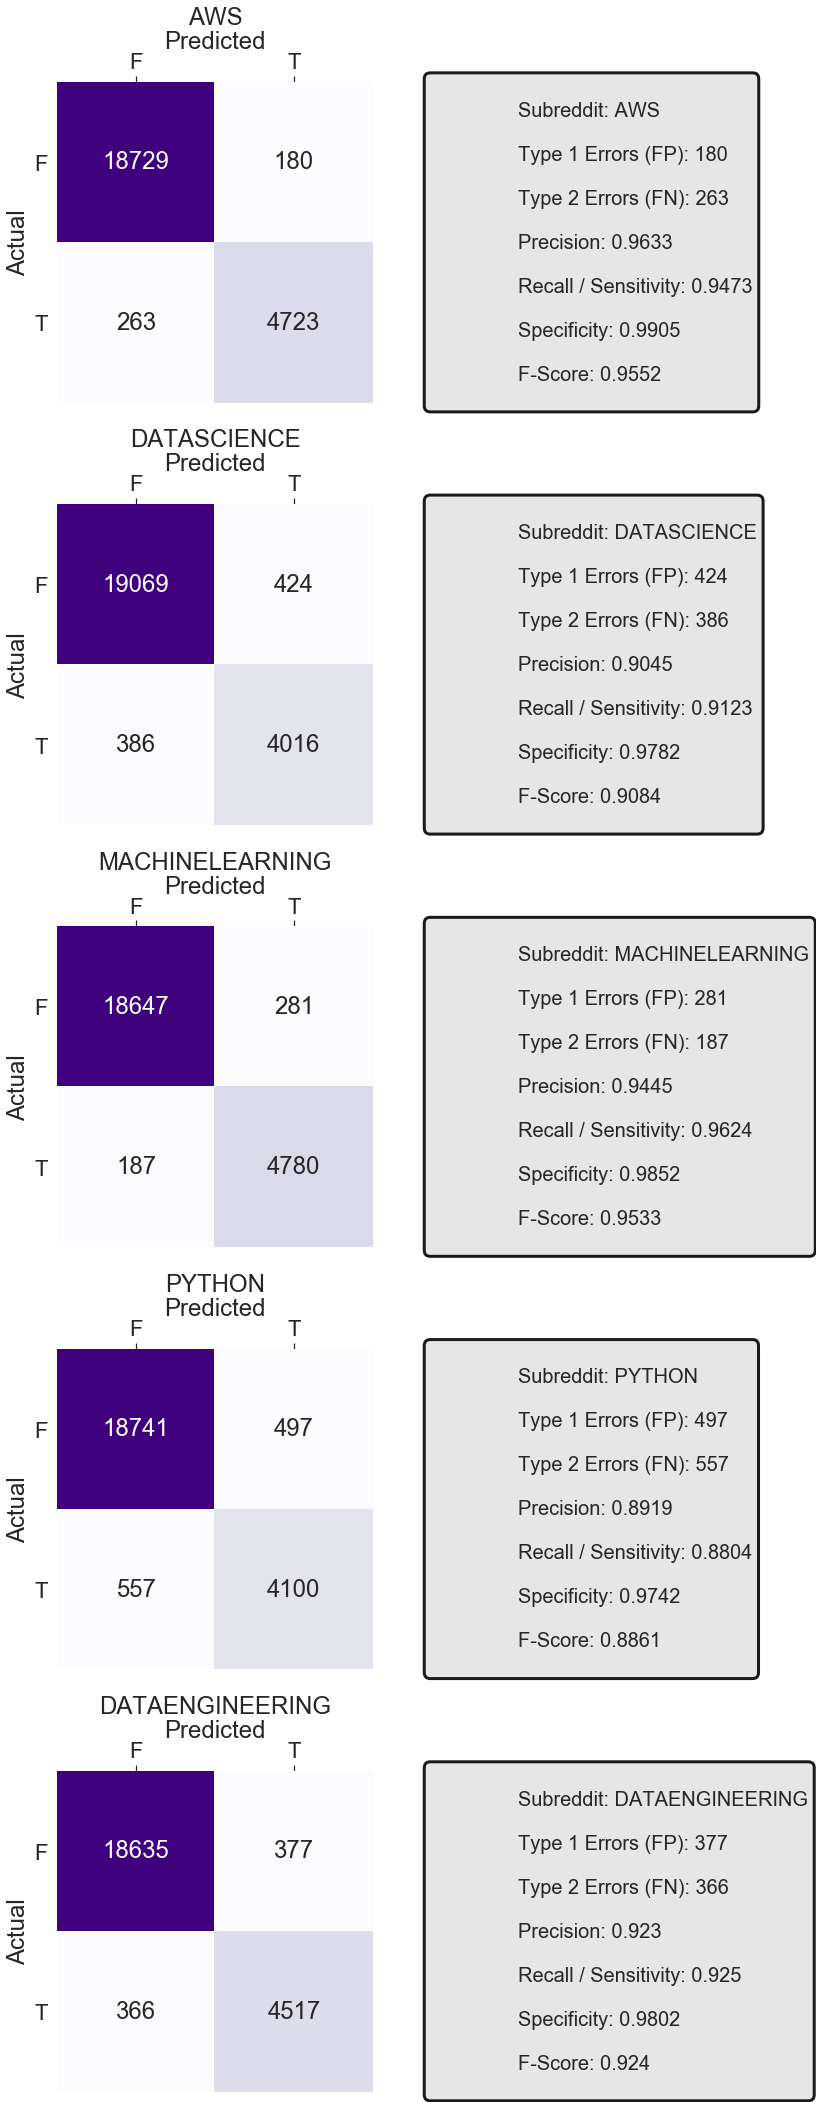

In [141]:
mcm = multilabel_confusion_matrix(y, y_pred)
mtn = mcm[:, 0, 0]
mtp = mcm[:, 1, 1]
mfn = mcm[:, 1, 0]
mfp = mcm[:, 0, 1]

fig, ax = plt.subplots(ncols=2, nrows=len(classes),
                       figsize=(12, 6*len(classes)))

for i, cm in enumerate(mcm):
    df_cm = pd.DataFrame(cm)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, annot=True, fmt="d", cbar=False,
                cmap='Purples', ax=ax[i, 0])

    ax[i, 0].set_yticklabels(labels=['F', 'T'], rotation='horizontal')
    ax[i, 0].set_xticklabels(labels=['F', 'T'])
    ax[i, 0].xaxis.tick_top()
    ax[i, 0].xaxis.set_label_position('top')
    ax[i, 0].set_title(classes[i].upper())

    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    recall = tp / (tp + fn)
    fscore = (2 * recall * precision) / (recall + precision)
    
    box_text = f'''
                Subreddit: {classes[i].upper()}\n
                Type 1 Errors (FP): {round(fp,4)}\n
                Type 2 Errors (FN): {round(fn,4)}\n
                Precision: {round(precision, 4)}\n
                Recall / Sensitivity: {round(recall,4)}\n
                Specificity: {round(specificity,4)}\n
                F-Score: {round(fscore,4)}
                '''
    ax[i, 1].text(0.1, 0.5,
                  box_text,
                  bbox=dict(
                            boxstyle="round",
                            ec=('k'),
                            lw=3,
                            fc=(.9,.9,.9),
                           ),
                  horizontalalignment='left',
                  verticalalignment='center',
                  fontsize=20)
    ax[i, 1].set_axis_off()

plt.tight_layout()

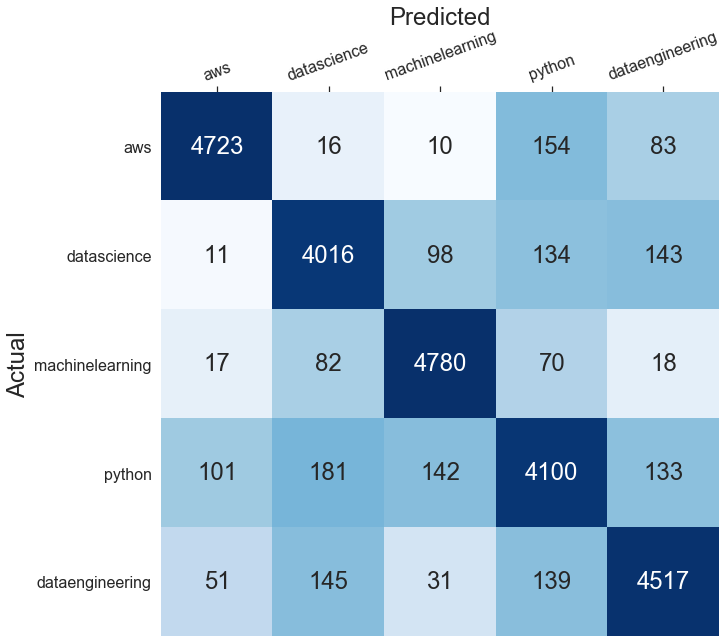

In [120]:
df_cm = pd.DataFrame(data=confusion_matrix(y, y_pred),
                     columns=classes, index=classes)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

fig, ax = plt.subplots(figsize=(2*len(classes),2*len(classes)))

sns.set(font_scale=2)
sns.heatmap(df_cm, 
            annot=True, 
            fmt="d", 
            cbar=False, 
            cmap='Blues', 
            ax=ax, 
            norm=LogNorm()
           )

fontdict={'fontsize': 16}

ax.set_yticklabels(labels=classes, rotation='horizontal', fontdict=fontdict)
ax.set_xticklabels(labels=classes, rotation=20, fontdict=fontdict)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [110]:
print(classification_report(y, y_pred, digits=3, target_names=classes))

                 precision    recall  f1-score   support

            aws      0.963     0.947     0.955      4986
    datascience      0.905     0.912     0.908      4402
machinelearning      0.944     0.962     0.953      4967
         python      0.892     0.880     0.886      4657
dataengineering      0.923     0.925     0.924      4883

       accuracy                          0.926     23895
      macro avg      0.925     0.925     0.925     23895
   weighted avg      0.926     0.926     0.926     23895



## Which ones are we missing?

<h1>TODO:</h1>

1. Make it have the roc for each sub, have to get into the original df where subname equals indexes?

In [ ]:
plot_roc_curve(model, X, y)

In [32]:
probs_df = pd.DataFrame(data=y_probs, columns=classes)
probs_df['predicted'] = labeler.inverse_transform(y_pred)
probs_df['actual'] = df['subreddit']
probs_df.head(10)

,aws,datascience,machinelearning,python,dataengineering,predicted,actual
0,0.965581,0.008758,0.010617,0.007365,0.007680,aws,aws
1,0.597527,0.078223,0.086714,0.096555,0.140981,aws,aws
2,0.718593,0.082820,0.043040,0.083832,0.071715,aws,aws
3,0.968823,0.005927,0.007001,0.013155,0.005095,aws,aws
4,0.786532,0.079607,0.042460,0.031961,0.059440,aws,aws
5,0.926543,0.011956,0.033573,0.013134,0.014794,aws,aws
6,0.860434,0.039891,0.019300,0.040728,0.039647,aws,aws
7,0.852800,0.050019,0.014980,0.056728,0.025474,aws,aws
8,0.703105,0.087590,0.068763,0.084490,0.056051,aws,aws
9,0.804698,0.035114,0.011264,0.078678,0.070246,aws,aws


In [52]:
for label in probs_df:
    # only probs for this label
    probs_y = probs_df[label]
    # get the index from df
    label_index = df.index[df['subreddit'] == label].tolist()
    # get matching y values
    true_y = y[label_index]
    print(roc_auc_score(y, probs_y, multi_class='ovr'))

AxisError: axis 1 is out of bounds for array of dimension 1

In [33]:
auc = roc_auc_score(y, y_probs, multi_class='ovr')
auc

0.9908630159456585

In [53]:
# not multiclass
fpr, tpr, thresholds = roc_curve(y, y_probs[0])

ValueError: multiclass format is not supported

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

In [ ]:
x1 = np.random.normal(0, 0.8, 1000)
x2 = np.random.normal(-2, 1, 1000)
x3 = np.random.normal(3, 2, 1000)
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
plt.hist(x1, **kwargs) 
plt.hist(x2, **kwargs) 
plt.hist(x3, **kwargs);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(y_probs, bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(probs[y_test == 0],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(probs[y_test == 1],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)